In [1]:
# import os
import glob
# import random

# import numpy as np
import pandas as pd
# import librosa
# from specAugment.spec_augment_tensorflow import *

import lib_feature
from lib_augment import *

In [2]:
# priori knowledge
species_dict = {'NO': 0, 'BD': 1, 'MH': 2, 'CD': 3, 'STR': 4, 'SPT': 5, 'SPIN': 6, 'PLT': 7, 'RD': 8, 'RT': 9,
                'WSD': 10, 'FKW': 11, 'BEL': 12, 'KW': 13, 'WBD': 14, 'DUSK': 15, 'FRA': 16, 'PKW': 17, 'LPLT': 18,
                'NAR': 19, 'CLY': 20, 'SPE': 21, 'ASP': 22}
species_all = list(species_dict.keys())
datasets = ['oswald', 'gillispie', 'dclde2011', 'watkin']

fs = 48000
time_reso = 0.02
hop_length = int(time_reso*fs)

clip_length = 2*fs  # 96,000 samples
freq_low = 50  # mel-scale =~ 2 kHz
shift_time_max = int(0.5/time_reso)
shift_freq_max = 10

random.seed(0)

# where the sound clips are
dataset_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset'

clip_paths = dict()
for dd in datasets:
    clip_paths.update({dd: os.path.join(dataset_path, '__'+dd, '__sound_clips')})

In [3]:
# statistics of sound clips
print('Build labels & dataframe from the filenames')
dataset_df = dict()
for dd in datasets:
    # for dd in [datasets[0]]:
    print('..'+dd)
    # search by the species names in the filenames
    wav_list = glob.glob(clip_paths[dd]+'/*.wav')
    wav_list.sort()
    wav_basename = [os.path.basename(ww) for ww in wav_list]

    species_list = []
    clip_id = []
    deployment_list = []
    for ww in range(len(wav_basename)):
        species_file, clipid_file, deploy_file = wavname_to_meta(wav_basename[ww], dd)
        species_list.append(species_file)
        clip_id.append(clipid_file)
        deployment_list.append(deploy_file)

    # build dataframe: dataset, base filename, species, clip id
    dataset_df.update({dd: pd.DataFrame(list(zip([dd]*len(wav_basename), wav_basename, species_list, clip_id, deployment_list)),
                                        columns=['dataset', 'filename', 'species', 'id', 'deployment'])})


Build labels & dataframe from the filenames
..oswald
..gillispie
..dclde2011
..watkin


In [4]:
df_total = pd.concat(list(dataset_df.values()))

In [5]:
df_species = df_total[df_total['species']!='NO']
df_noise = df_total[df_total['species'] == 'NO']

df_species.shape

(88328, 5)

In [6]:
from lib_augment import *
%matplotlib inline
import librosa
from librosa.display import specshow
import matplotlib.pyplot as plt

In [39]:
def spectrogram_draw(spectro, row, fs, hop_length):
    float_min = 1.e-10
    spectro_log_in = 20*np.log10(spectro+float_min)

    spectro_log_in = spectro_log_in - spectro_log_in.max()
    spectro_log_in_max = spectro_log_in.max()
    spectro_log_in[spectro_log_in < spectro_log_in_max-100] = spectro_log_in_max - 100

    plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots(1, 1)
    ax.title.set_text(row['dataset']+' '+row['species'])
    specshow(spectro_log_in, sr=fs, hop_length=hop_length, y_axis='mel', x_axis='time', fmax=24000, ax=ax)

## Original sound clip

In [71]:
row  = (df_species[ (df_species['species']=='BD') & (df_species['dataset']=='oswald')].sample(1)).iloc[0]
# df_bd  = df_species[df_species['species']=='BD'].sample(20)

<Figure size 864x432 with 0 Axes>

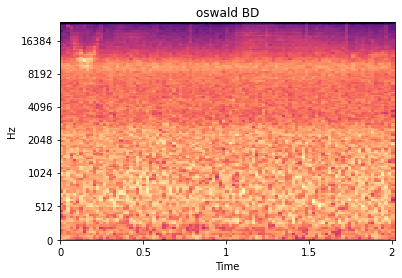

In [72]:
import warnings
warnings.filterwarnings("ignore",category=UserWarning)

curr_clip_path = os.path.join(dataset_path, '__'+row['dataset'], '__sound_clips', row['filename'])
samples = load_and_normalize(curr_clip_path, sr=fs, clip_length=clip_length)
spectro = librosa.feature.melspectrogram(samples, sr=fs, hop_length=hop_length, power=1)
spectrogram_draw(spectro, row, fs, hop_length)

## feature whistleness: median filter to remove clicks, remove tonal noise & PCEN

In [73]:
spectro_fea = lib_feature.feature_whistleness(spectro)

<Figure size 864x432 with 0 Axes>

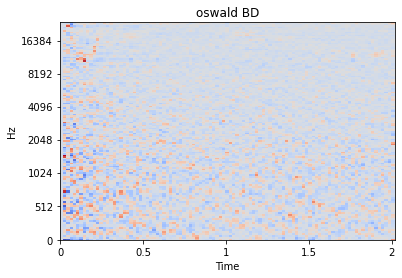

In [74]:
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(1, 1)
ax.title.set_text(row['dataset']+' '+row['species'])
specshow(spectro_fea.T, sr=fs, hop_length=hop_length, y_axis='mel', x_axis='time', fmax=24000, ax=ax)

In [ ]:
from skimage.feature import hog, corner_orientations

In [ ]:
fd, hog_image = hog(np.expand_dims(spectro_fea.T, 2), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True, multichannel=True)

In [ ]:
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(1, 1)
ax.title.set_text(row['dataset']+' '+row['species'])
specshow(hog_image, sr=fs, hop_length=hop_length, y_axis='linear', x_axis='time', ax=ax)